In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Chage cwd
os.chdir('c:\\Users\\tyler\\OneDrive\\Documents\\Python\\MLB')
print(f'CWD: \n{os.getcwd()}')

CWD: 
c:\Users\tyler\OneDrive\Documents\Python\MLB


In [3]:
# Load schedules
schedule = pd.DataFrame()
for season in range(2022-5, 2022):
    schedule = schedule.append(pd.read_csv(f'backend/data/schedules/{season}.csv'), ignore_index=True)

schedule['date'] = pd.to_datetime(schedule['date'])
schedule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10815 entries, 0 to 10814
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     10815 non-null  datetime64[ns]
 1   visitor  10815 non-null  object        
 2   home     10815 non-null  object        
 3   season   10815 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 338.1+ KB


In [4]:
# Load scores
scores = pd.read_csv('backend/data/scores/boxscore.csv')
scores['date'] = pd.to_datetime(scores['date'])

scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22148 entries, 0 to 22147
Data columns (total 26 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     22148 non-null  datetime64[ns]
 1   visitor  22148 non-null  object        
 2   home     22148 non-null  object        
 3   team     22148 non-null  object        
 4   1        22148 non-null  int64         
 5   2        22148 non-null  int64         
 6   3        22148 non-null  int64         
 7   4        22148 non-null  int64         
 8   5        22148 non-null  object        
 9   6        22140 non-null  object        
 10  7        22124 non-null  object        
 11  8        21700 non-null  object        
 12  9        21646 non-null  object        
 13  R        22148 non-null  int64         
 14  H        22148 non-null  int64         
 15  E        22148 non-null  int64         
 16  10       1834 non-null   float64       
 17  11       844 non-null    float6

In [5]:
# Load batting totals
batting_totals = pd.read_csv('backend/data/batting/totals.csv')
batting_totals['date'] = pd.to_datetime(batting_totals['date'])
batting_totals['wpa-'] = batting_totals['wpa-'].apply(lambda x: float(x.strip("%")))
batting_totals['cwpa'] = batting_totals['cwpa'].apply(lambda x: float(x.strip("%")))
batting_totals = batting_totals.fillna(0)
batting_totals = batting_totals[batting_totals['ab'] != 0]

batting_totals.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22148 entries, 0 to 22147
Data columns (total 46 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     22148 non-null  datetime64[ns]
 1   visitor  22148 non-null  object        
 2   home     22148 non-null  object        
 3   team     22148 non-null  object        
 4   ab       22148 non-null  int64         
 5   r        22148 non-null  int64         
 6   h        22148 non-null  int64         
 7   rbi      22148 non-null  int64         
 8   bb       22148 non-null  int64         
 9   so       22148 non-null  int64         
 10  pa       22148 non-null  int64         
 11  ba       22148 non-null  float64       
 12  obp      22148 non-null  float64       
 13  slg      22148 non-null  float64       
 14  ops      22148 non-null  float64       
 15  pit      22148 non-null  int64         
 16  str      22148 non-null  int64         
 17  wpa      22148 non-null  float6

In [6]:
# Function for feature engineering stats
def feature_engineer(df):
   df['ba'] = df['h'] / df['ab']
   df['obp'] = (df['h'] + df['bb'] + df['hbp']) / (df['ab'] + df['bb'] + df['hbp'] + df['sf'])
   df['1b'] = df['h'] - (df['2b'] + df['3b'] + df['hr'])
   df['slg'] = (df['1b'] + 2*df['2b'] + 3*df['3b'] + 4*df['hr']) / df['ab']
   df['ops'] = df['obp'] + df['slg']

   return df
   

In [7]:
# Function for sma
def sma(bin, df):

    sma_df = pd.DataFrame()
    
    for team in df['team'].unique():
        for season in df['date'].dt.year.unique():
            team_df = df[(df['team'] == team) & (df['date'].dt.year == season)].sort_values(by=['date']).copy()
            for col in list(set(df.columns).difference({'date', 'visitor', 'home', 'team'})):
                team_df[col] = team_df[col].rolling(bin, closed='left').mean()
            
            sma_df = sma_df.append(team_df, ignore_index=True)
    
    sma_df = pd.merge(
        sma_df, 
        df[['date', 'visitor', 'home', 'team', 'h']],
        left_on=['date', 'visitor', 'home', 'team'], 
        right_on=['date', 'visitor', 'home', 'team'],
        suffixes=('', '_target')
    )

    sma_df = feature_engineer(sma_df)

    return sma_df.sort_values(by=['date'])

In [8]:
# Function for cma
def cma(df, schedule):

    df = pd.merge(
        schedule.drop(['season'], axis=1),
        df,
        left_on=['date', 'visitor', 'home'],
        right_on=['date', 'visitor', 'home'],
        how='left'
    )

    cma_df = pd.DataFrame()

    for team in df['team'].unique():
        for season in df['date'].dt.year.unique():
            team_df = df[(df['team'] == team) & (df['date'].dt.year == season)].sort_values(by=['date']).copy()
            for col in list(set(df.columns).difference({'date', 'visitor', 'home', 'team'})):
                team_df[col] = team_df[col].expanding(1).mean()
                team_df[col] = team_df[col].shift(1)
            
            cma_df = cma_df.append(team_df, ignore_index=True)
    
    cma_df = pd.merge(
        cma_df, 
        df[['date', 'visitor', 'home', 'team', 'h']],
        left_on=['date', 'visitor', 'home', 'team'], 
        right_on=['date', 'visitor', 'home', 'team'],
        suffixes=('', '_target')
    )

    cma_df = feature_engineer(cma_df)

    return cma_df.sort_values(by=['date'])

In [9]:
# Function for ema
def ema(df, schedule):

    df = pd.merge(
        schedule.drop(['season'], axis=1),
        df,
        left_on=['date', 'visitor', 'home'],
        right_on=['date', 'visitor', 'home'],
        how='left'
    )

    ema_df = pd.DataFrame()

    for team in df['team'].unique():
        for season in df['date'].dt.year.unique():
            team_df = df[(df['team'] == team) & (df['date'].dt.year == season)].sort_values(by=['date']).copy()
            for col in list(set(df.columns).difference({'date', 'visitor', 'home', 'team'})):
                team_df[col] = team_df[col].ewm(alpha=2 / 3).mean()
                team_df[col] = team_df[col].shift(1)
            
            ema_df = ema_df.append(team_df, ignore_index=True)
    
    ema_df = pd.merge(
        ema_df, 
        df[['date', 'visitor', 'home', 'team', 'h']],
        left_on=['date', 'visitor', 'home', 'team'], 
        right_on=['date', 'visitor', 'home', 'team'],
        suffixes=('', '_target')
    )

    ema_df = feature_engineer(ema_df)

    return ema_df.sort_values(by=['date'])

In [10]:
# Apply SMA (season, last 20 games, last 10 games, last 5 games, last 3 games, last game)
cols = list(set(batting_totals.columns).difference({'obp', 'slg', 'ops', 'wpa', 'ali', 'wpa+', 'wpa-', 'cwpa', 'acli', 're24'}))
df = batting_totals[cols]
ema_batting_df = ema(df, schedule)
sma_batting_df = sma(10, df)
cma_batting_df = cma(df, schedule)

In [11]:
# Load pitching totals
pitching_totals = pd.read_csv('backend/data/pitching/totals.csv')
pitching_totals['date'] = pd.to_datetime(pitching_totals['date'])
pitching_totals['cwpa'] = pitching_totals['cwpa'].apply(lambda x: float(x.strip('%')))

pitching_totals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22148 entries, 0 to 22147
Data columns (total 30 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     22148 non-null  datetime64[ns]
 1   visitor  22148 non-null  object        
 2   home     22148 non-null  object        
 3   team     22148 non-null  object        
 4   ip       22148 non-null  float64       
 5   h        22148 non-null  int64         
 6   r        22148 non-null  int64         
 7   er       22148 non-null  int64         
 8   bb       22148 non-null  int64         
 9   so       22148 non-null  int64         
 10  hr       22148 non-null  int64         
 11  era      22148 non-null  float64       
 12  bf       22148 non-null  int64         
 13  pit      22148 non-null  int64         
 14  str      22148 non-null  int64         
 15  ctct     22148 non-null  int64         
 16  sts      22148 non-null  int64         
 17  stl      22148 non-null  int64 

In [12]:
# Function for feature engineering stats
def feature_engineer(df):
   df['era'] = 9 * df['er'] / df['ip']

   return df

In [13]:
# Apply SMA (season, last 20 games, last 10 games, last 5 games, last 3 games, last game)
cols = list(set(pitching_totals.columns).difference({'era', 'gsc', 'wpa', 'ali', 'cwpa', 'acli', 're24'}))
df = pitching_totals[cols]
cma_pitching_df = cma(df, schedule)
ema_pitching_df = ema(df, schedule)
sma_pitching_df = sma(10, df)

In [14]:
# Average pitching and batting data
dfs = {
    'cma': (cma_batting_df, cma_pitching_df), 
    'sma': (sma_batting_df, sma_pitching_df), 
    'ema': (ema_batting_df, ema_pitching_df)
}
for key in dfs:
    batting_df = dfs[key][0]
    pitching_df = dfs[key][1]

    batting_df['opponent'] = np.where(batting_df['team'] == batting_df['home'], batting_df['visitor'], batting_df['home'])

    df = pd.merge(
        batting_df[['date', 'visitor', 'home', 'team', 'opponent', 'h', 'h_target']], 
        pitching_df[['date', 'visitor', 'home', 'team', 'h']], 
        left_on=['date', 'visitor', 'home', 'opponent'],
        right_on=['date', 'visitor', 'home', 'team'],
        suffixes=['_batting', '_pitching']
    )

    df['h'] =  (df['h_batting'] * 0.5) + (df['h_pitching'] * 0.5)
    corr = round(df['h'].corr(df['h_target']) * 100)
    print(f'{key.upper()} Correlation: {corr}%')


CMA Correlation: 29%
SMA Correlation: 13%
EMA Correlation: 49%


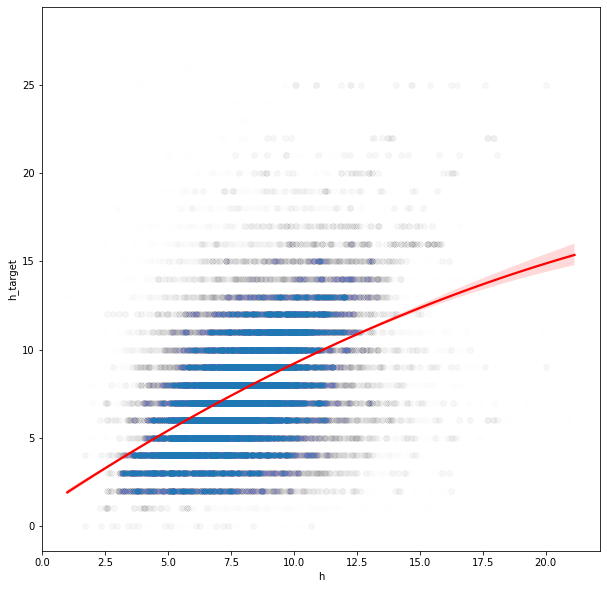

In [17]:
# Graph
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

sns.regplot(
    data=df, 
    x='h',
    y='h_target',
    order=2,
    ax=ax, 
    scatter_kws={'alpha':0.004}, 
    line_kws={"color": "red"}
    )

plt.show()

In [19]:
# Load pitching details
pitching_details = pd.read_csv('backend/data/pitching/details.csv')
pitching_details['date'] = pd.to_datetime(pitching_details['date'])
pitching_details['cwpa'] = pitching_details['cwpa'].apply(lambda x: float(x.strip('%')))

pitching_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97098 entries, 0 to 97097
Data columns (total 31 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     97098 non-null  datetime64[ns]
 1   visitor  97098 non-null  object        
 2   home     97098 non-null  object        
 3   team     97098 non-null  object        
 4   player   97098 non-null  object        
 5   ip       97098 non-null  float64       
 6   h        97098 non-null  int64         
 7   r        97098 non-null  int64         
 8   er       97098 non-null  int64         
 9   bb       97098 non-null  int64         
 10  so       97098 non-null  int64         
 11  hr       97098 non-null  int64         
 12  era      97063 non-null  float64       
 13  bf       97098 non-null  int64         
 14  pit      97073 non-null  float64       
 15  str      97073 non-null  float64       
 16  ctct     96995 non-null  float64       
 17  sts      97073 non-null  float6

In [23]:
# Divide pitchers into starters and bullpen
starters_df = pd.DataFrame()
bullpen_df = pd.DataFrame()

for team in pitching_details['team'].unique():
    for season in pitching_details['date'].dt.year.unique():
        team_df = pitching_details[(pitching_details['team'] == team) & (pitching_details['date'].dt.year == season)].copy()
        for date in team_df['date']:
            game_df = team_df[team_df['date'] == date]
            starters_df = starters_df.append(game_df.iloc[0, :], ignore_index=True)
            bullpen_df = bullpen_df.append(game_df.iloc[1:, :], ignore_index=True)

KeyboardInterrupt: 

In [ ]:
starters_df.sample(5)